# What are the database technologies, web framemworks, and other tools and libreries that most satisified software developers are using?

### Business Understanding

If you are a seasoned software developer or a newbee who just want to be a software developer, you may want to know answers to the questions like: 
What are the database technologies, web framemworks, and other tools and libreries that most satisified developers are using?

To answer these questions, I used data from Stackoverflow's 2019 Annual Developer Survey. 
The survey data covers 88,863 reviews from 213 countries and territories.

### Data Understanding

To get started, let's read in the necessary libraries we will need to wrangle our data: pandas and numpy. 
If we decided to build some basic plots, matplotlib and seaborn might prove useful as well.

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline
from collections import defaultdict
import matplotlib.pyplot as plt

df = pd.read_csv('./survey_results_public_2019.csv')
df.head()

,Respondent,MainBranch,Hobbyist,OpenSourcer,OpenSource,Employment,Country,Student,EdLevel,UndergradMajor,...,WelcomeChange,SONewContent,Age,Gender,Trans,Sexuality,Ethnicity,Dependents,SurveyLength,SurveyEase
0,1,I am a student who is learning to code,Yes,Never,The quality of OSS and closed source software ...,"Not employed, and not looking for work",United Kingdom,No,Primary/elementary school,NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,14.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
1,2,I am a student who is learning to code,No,Less than once per year,The quality of OSS and closed source software ...,"Not employed, but looking for work",Bosnia and Herzegovina,"Yes, full-time","Secondary school (e.g. American high school, G...",NaN,...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,19.0,Man,No,Straight / Heterosexual,NaN,No,Appropriate in length,Neither easy nor difficult
2,3,"I am not primarily a developer, but I write co...",Yes,Never,The quality of OSS and closed source software ...,Employed full-time,Thailand,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Web development or web design,...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,28.0,Man,No,Straight / Heterosexual,NaN,Yes,Appropriate in length,Neither easy nor difficult
3,4,I am a developer by profession,No,Never,The quality of OSS and closed source software ...,Employed full-time,United States,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech articles written by other developers;Indu...,22.0,Man,No,Straight / Heterosexual,White or of European descent,No,Appropriate in length,Easy
4,5,I am a developer by profession,Yes,Once a month or more often,"OSS is, on average, of HIGHER quality than pro...",Employed full-time,Ukraine,No,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",...,Just as welcome now as I felt last year,Tech meetups or events in your area;Courses on...,30.0,Man,No,Straight / Heterosexual,White or of European descent;Multiracial,No,Appropriate in length,Easy


In [32]:
# Let's look at the CareerSat column as shown below
df["CareerSat"].value_counts()

Very satisfied                        29173
Slightly satisfied                    25018
Slightly dissatisfied                  7670
Neither satisfied nor dissatisfied     7252
Very dissatisfied                      3734
Name: CareerSat, dtype: int64

### A brief note on scoring the satisfaction

I've used a technique inspired by NPS Scoring technique, to quantify the satisfaction rating before I calculated the average. The rating used is below:

For more details on NPS scoring refer https://www.qualtrics.com/experience-management/customer/measure-nps/

In [33]:
# Create a numeric rating to replace
nps_numeric_ratings = {"CareerSat": {"Very satisfied": 4, "Slightly satisfied": 2, 
                                     "Neither satisfied nor dissatisfied" : 0,
                                    "Slightly dissatisfied": -2, "Very dissatisfied": -4}}

In [34]:
# drop all records without any career satisfaction value
df_valid_careersat = df.dropna(subset=["CareerSat"], how='any').reset_index(drop=True)

In [35]:
# Now replace the career rating with numeric values
df_valid_careersat.replace(nps_numeric_ratings, inplace=True)

In [36]:
# Verify the field again
df_valid_careersat["CareerSat"].value_counts()

 4    29173
 2    25018
-2     7670
 0     7252
-4     3734
Name: CareerSat, dtype: int64

In [37]:
# let's look at all the programming languages now

In [38]:
df.LanguageWorkedWith.value_counts()

HTML/CSS;JavaScript;PHP;SQL                                                                                          1483
C#;HTML/CSS;JavaScript;SQL                                                                                           1414
HTML/CSS;JavaScript                                                                                                  1247
C#;HTML/CSS;JavaScript;SQL;TypeScript                                                                                 990
Java                                                                                                                  934
HTML/CSS;JavaScript;PHP                                                                                               910
Python                                                                                                                759
HTML/CSS;JavaScript;TypeScript                                                                                        703
HTML/CSS;Java;JavaScript

In [39]:
# This isn't what I was expecting, it is grouping programming languages together 
# So one row has more than just one answer.  I write a function to clean it up. 
# Following function will create a dictionary with all programming languages and counts. 
# We can use the dictionary to get TOP languages and also do some data visualizations. 

def create_dict_from_col(schema, column):
    '''
    INPUT 
        schema - a dataframe schema name
        column - column name with ';' seperator     
    OUTPUT
        desired_lang_dict - a dictionary with list of category names and their counts
    '''
    df_new = schema[schema[column].notnull()] # Remove NaN records
    desired_lang_dict = {} # Initialize the dict
    # Populate the dict
    for row in df_new[column].to_list():
        languages = row.split(';')
        for each_lang in languages:
            if each_lang in desired_lang_dict:
                desired_lang_dict[each_lang] += 1
            else:
                desired_lang_dict[each_lang] = 1
    return desired_lang_dict

In [40]:
# This is a short utility function we can use to get TOP N categories 
def get_dict_topvals(dict, top_n,is_reverse):
    return sorted(dict.items(), key=lambda x: x[1], reverse = is_reverse)[:top_n] 

In [41]:
# Using above functions we can easily get a list of all languages worked by the survey responders.
lang_list = create_dict_from_col(df,'LanguageWorkedWith').keys()  
lang_list  

dict_keys(['HTML/CSS', 'Java', 'JavaScript', 'Python', 'C++', 'C', 'C#', 'SQL', 'VBA', 'R', 'Bash/Shell/PowerShell', 'Ruby', 'Rust', 'TypeScript', 'WebAssembly', 'Other(s):', 'Go', 'PHP', 'Assembly', 'Kotlin', 'Swift', 'Objective-C', 'Elixir', 'Erlang', 'Clojure', 'F#', 'Scala', 'Dart'])

In [42]:
# Let's write a function to give us average salaries of developers using those languages. 
# I've written the following generic fucntion

def get_mean_by_column_values(df,col_list,col_name,mean_col_name):
    '''
    INPUT 
        schema - a dataframe schema name
        col_list - a Python list with all category values
        col_name - category column name
        mean_col_name - column that we apply the average (should be int ot float)
    OUTPUT
        df_means - a sorted data farme with each category name and mean of the column supplied in mean_col_name column 
    '''
    # drop any row with null values in mean_col_name    
    df_notnull = df.dropna(subset=[mean_col_name,col_name], how='any')
    df_final = df_notnull[[mean_col_name,col_name]].reset_index(drop=True)
    
    df_subset = defaultdict(float)
    denoms = dict()
    for val in col_list:
        denoms[val] = 0
        for row_num in range(df_final.shape[0]):
            if val in df_final[col_name][row_num]:
                df_subset[val] += df_final[mean_col_name][row_num]
                denoms[val] += 1
    
    df_subset = pd.DataFrame(pd.Series(df_subset)).reset_index()
    denoms = pd.DataFrame(pd.Series(denoms)).reset_index()  
    df_subset.columns = [mean_col_name, 'col_sum']
    denoms.columns = [mean_col_name, 'col_total']
    
    df_subset.columns = [col_name, 'col_sum']
    denoms.columns = [col_name, 'col_total']
    df_means = pd.merge(df_subset, denoms)
    df_means['mean_col'] = df_means['col_sum']/df_means['col_total']
    
    return df_means.sort_values('mean_col', ascending=False)

In [43]:
# This utility function will create a bar plot from the dictionary obtained 
def plot_bar_on_df(df, x_col, y_col, title, ip_palette="Rocket"):
    '''
    INPUT 
        df - a data frame
        x_col - Name of the X axis - category name
        y_col - Name of the Y axis - stores count
        title - title of the bar chart
    OUTPUT
        bar chart
    '''
    df_lang = df.sort_values(by=y_col, ascending=False)
    sns.set(style="white", context="talk")
    sns.set(rc={'figure.figsize':(12.1,8.5)})
    tips = sns.load_dataset("tips")
    ax = sns.barplot(x=x_col, y = y_col, data=df_lang, palette=ip_palette)
    ax.axhline(0, color="k", clip_on=False)
    ax.set(xlabel=x_col, ylabel=y_col)
    ax.set_title(title,fontsize=20)
    ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right',fontweight='light')

####  1. What are the programming languages that most satisfied software developers are using ?
Let's get answer to the above question using the function we have just written.

In [47]:
# Using above functions we can easily get a list of all categories.
lang_list = create_dict_from_col(df,'LanguageWorkedWith').keys()  
# Calculate average satisfaction for each categroies 
lang_sat = get_mean_by_column_values(df_valid_careersat,lang_list,'LanguageWorkedWith','CareerSat')
lang_sat = lang_sat.rename(columns={"mean_col": "Average_Satisfaction_Score", "col_total": "Count"})
lang_sat[['LanguageWorkedWith','Average_Satisfaction_Score']]

,LanguageWorkedWith,Average_Satisfaction_Score
24,Clojure,2.294490
16,Go,2.114798
11,Ruby,2.089200
12,Rust,2.078176
22,Elixir,2.067736
25,F#,2.067081
13,TypeScript,2.050411
9,R,2.049763
26,Scala,2.045364
10,Bash/Shell/PowerShell,2.043556


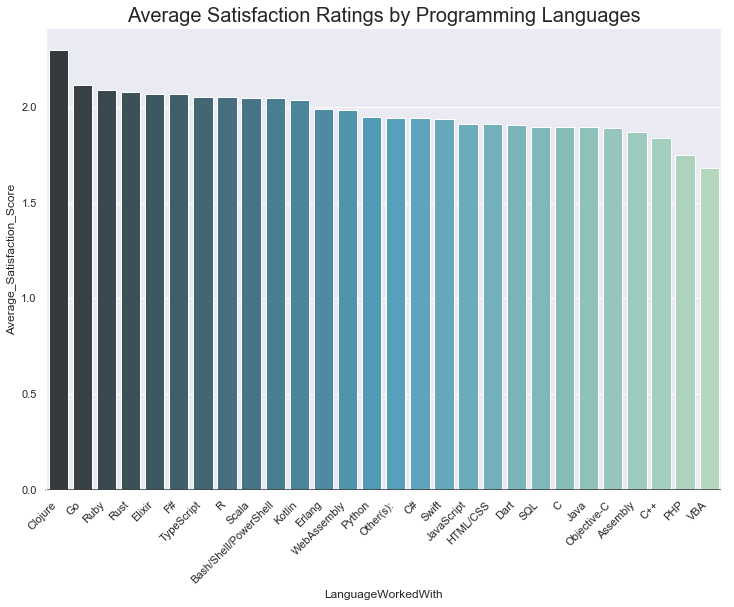

In [45]:
plot_bar_on_df(lang_sat, 'LanguageWorkedWith', 
               'Average_Satisfaction_Score', "Average Satisfaction Ratings by Programming Languages","GnBu_d")

####  2. What are the database technologies that most satisfied software developers are using ?
Let's get answer to the above question using the function we have just written.

In [46]:
db_list = create_dict_from_col(df,'DatabaseWorkedWith').keys()  
# Calculate average satisfaction for each categroies 
db_sat = get_mean_by_column_values(df_valid_careersat,db_list,'DatabaseWorkedWith','CareerSat')
db_sat = db_sat.rename(columns={"mean_col": "Average_Satisfaction_Score", "col_total": "Count"})
db_sat

,DatabaseWorkedWith,col_sum,Count,Average_Satisfaction_Score
9,DynamoDB,9594.0,4344,2.208564
7,Elasticsearch,21206.0,10171,2.084947
8,Redis,27122.0,13182,2.057503
13,Other(s):,9328.0,4545,2.052365
1,PostgreSQL,45554.0,23184,1.964890
3,Couchbase,2678.0,1390,1.926619
11,Firebase,14922.0,7838,1.903802
4,MongoDB,31534.0,16571,1.902963
10,Microsoft SQL Server,41658.0,21989,1.894493
6,Cassandra,4452.0,2365,1.882452


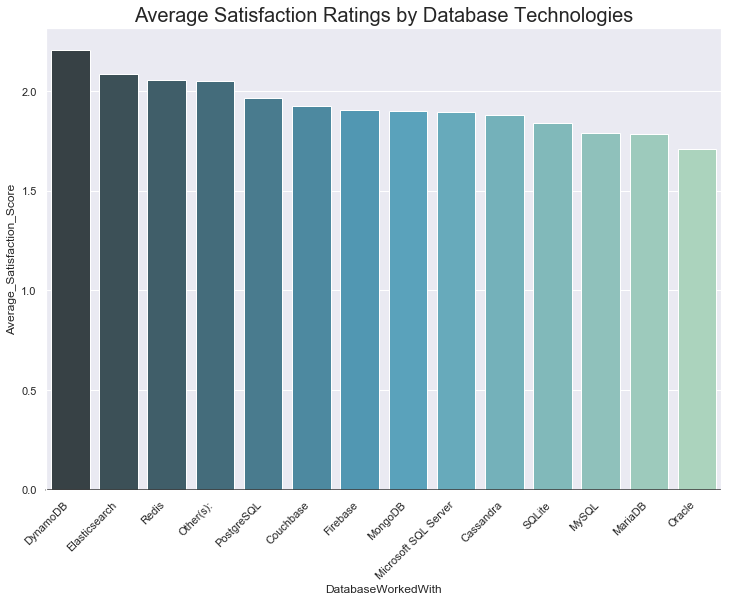

In [17]:
plot_bar_on_df(db_sat, 'DatabaseWorkedWith', 
               'Average_Satisfaction_Score', "Average Satisfaction Ratings by Database Technologies","GnBu_d")

####  3. What are the web frameworks that most satisfied software developers are using ?
Let's get answer to the above question using the function we have just written.

In [18]:
web_list = create_dict_from_col(df,'WebFrameWorkedWith').keys()  
# Calculate average satisfaction for each categroies 
web_sat = get_mean_by_column_values(df_valid_careersat,web_list,'WebFrameWorkedWith','CareerSat')
web_sat = web_sat.rename(columns={"mean_col": "Average_Satisfaction_Score", "col_total": "Count"})
web_sat

,WebFrameWorkedWith,col_sum,Count,Average_Satisfaction_Score
6,Ruby on Rails,9460.0,4610,2.052061
4,React.js,36220.0,17700,2.046328
7,Other(s):,9366.0,4696,1.994463
10,Vue.js,16744.0,8518,1.965720
1,Flask,12540.0,6382,1.964901
2,Express,21002.0,10705,1.961887
9,ASP.NET,28868.0,14932,1.933298
8,Angular/Angular.js,34294.0,17798,1.926846
0,Django,12536.0,6715,1.866865
3,jQuery,48330.0,26479,1.825220


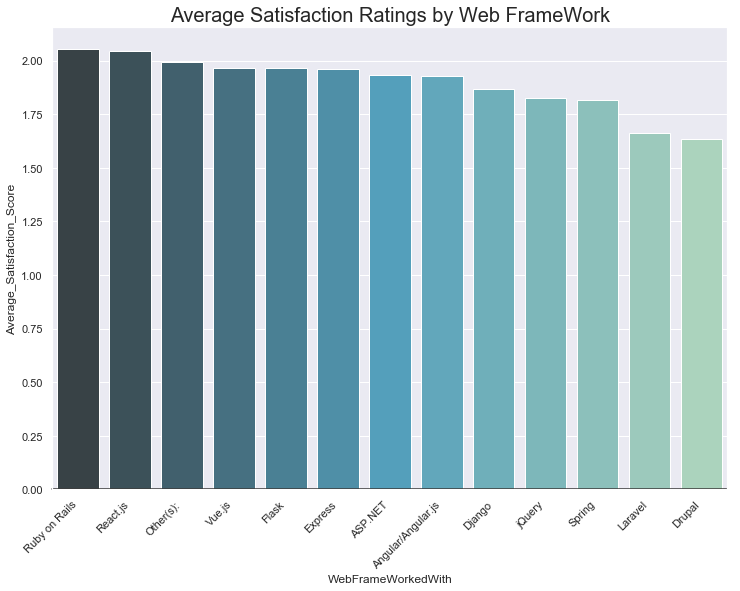

In [19]:
plot_bar_on_df(web_sat, 'WebFrameWorkedWith', 
               'Average_Satisfaction_Score', "Average Satisfaction Ratings by Web FrameWork","GnBu_d")

####  3. What are the tools/libraries/miscelleneous frameworks  that most satisfied software developers are using ?
Let's get answer to the above question using the function we have just written.

In [20]:
tech_list = create_dict_from_col(df,'MiscTechWorkedWith').keys()  
# Calculate average satisfaction for each categroies 
tech_sat = get_mean_by_column_values(df_valid_careersat,tech_list,'MiscTechWorkedWith','CareerSat')
tech_sat = tech_sat.rename(columns={"mean_col": "Average_Satisfaction_Score", "col_total": "Count"})
tech_sat

,MiscTechWorkedWith,col_sum,Count,Average_Satisfaction_Score
8,Chef,2830.0,1343,2.107223
7,Ansible,10680.0,5153,2.072579
13,Puppet,2940.0,1420,2.070423
11,.NET Core,24922.0,12175,2.046982
15,Apache Spark,5886.0,2936,2.004768
14,Other(s):,4578.0,2314,1.978392
0,Node.js,49234.0,25013,1.968336
12,React Native,10502.0,5346,1.964459
1,.NET,39568.0,20305,1.948683
9,TensorFlow,9028.0,4654,1.939837


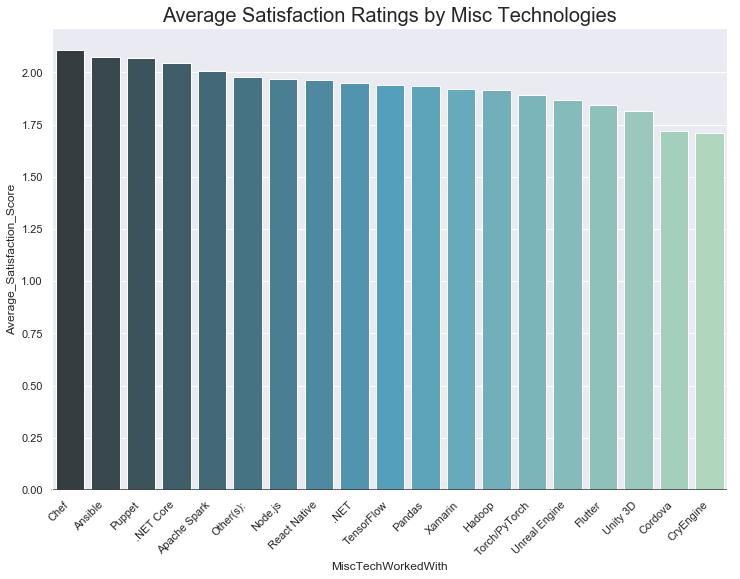

In [21]:
plot_bar_on_df(tech_sat, 'MiscTechWorkedWith', 
               'Average_Satisfaction_Score', "Average Satisfaction Ratings by Misc Technologies","GnBu_d")